### Import 

In [1]:
import json
import os
import pandas as pd
import numpy as np
import string
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

### Load

In [3]:
path_business_toronto_rest = './data/toronto_restaurant_business.csv'

In [4]:
df_business_toronto_rest = pd.read_csv(path_business_toronto_rest, encoding='utf8')

---
### <font color='red'> 1. Visualize Toronto Restaurants:

In [5]:
import folium
from folium import plugins
from IPython.display import display, IFrame

In [6]:
lat_toronto = np.median(df_business_toronto_rest['latitude'])
lon_toronto = np.median(df_business_toronto_rest['longitude'])
map_toronto = folium.Map([lat_toronto, lon_toronto], zoom_start=20)  

#### <font color='blue'> a. Heatmap to show density of restaurants distribution

First of all, we will take a look at the distribution of all the restaurants in Toronto in order to spot any geographical trend.

In [7]:
heat = plugins.HeatMap(list(df_business_toronto_rest[['latitude', 'longitude']].values), radius=20)
heatmap_toronto = map_toronto.add_child(heat)

In [8]:
heatmap_toronto.save('heatmap_toronto.html')

In [9]:
display(IFrame(src='heatmap_toronto.html', width=1600, height=800))

From the heatmap above, the restaurants seem to spread quite uniformly. Then let us glance at the distribution of open and closed restaurants separately.

#### <font color='blue'> b. Map of open restaurants and closed restaurants

In [10]:
df_business_toronto_rest_open = df_business_toronto_rest[df_business_toronto_rest['is_open']==1]

In [11]:
df_business_toronto_rest_closed = df_business_toronto_rest[df_business_toronto_rest['is_open']==0]

In [12]:
map_toronto_open_closed = folium.Map([lat_toronto, lon_toronto], zoom_start=20) 

for index, row in df_business_toronto_rest_open.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=4,
                        color="red", fill_color="red", 
                        ).add_to(map_toronto_open_closed)

for index, row in df_business_toronto_rest_closed.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=4,
                        color="blue"
                        ).add_to(map_toronto_open_closed)

In [13]:
map_toronto_open_closed.save('map_toronto_open_closed.html')

In [14]:
display(IFrame(src='map_toronto_open_closed.html', width=1600, height=800))

No obvious clusters are shown overall, so analytical analysis will be done in further step.

---
### <font color='red'> 2. Prediction of restaurants' popularity class

The popularity of a restaurant is related to the amount of reviews it received and the stars it's been rated. Since it is difficult to determine the proportion of each parameter, so instead of turning popularity into the numerical measurement to predict a regression problem, we create an additional class according to reviews counts and stars to classify the popularity in this way.

#### <font color='blue'> a. Generate classes of popularity using reviews counts and stars

In [15]:
dummy = pd.DataFrame(columns=['popularity'])

> Pick `top 15%` quantile as popular bound for both review counts and stars

In [16]:
top_stars = df_business_toronto_rest.quantile(0.85).stars
top_review_counts = df_business_toronto_rest.quantile(0.85).review_count

In [17]:
df_business_toronto_rest_popular = pd.concat([df_business_toronto_rest, dummy])

> 0 in popularity: `high_rating & high_review_counts`

In [18]:
df_business_toronto_rest_popular.loc[:, 'popularity'][(df_business_toronto_rest['stars']>=top_stars) & (df_business_toronto_rest['review_count']>=top_review_counts)] = 0

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


> 1 in popularity: `low_rating & high_review_counts`

In [19]:
df_business_toronto_rest_popular.loc[:, 'popularity'][(df_business_toronto_rest['stars']<top_stars) & (df_business_toronto_rest['review_count']>=top_review_counts)] = 1

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


> 2 in popularity: `high_rating & low_review_counts`

In [20]:
df_business_toronto_rest_popular.loc[:, 'popularity'][(df_business_toronto_rest['stars']>=top_stars) & (df_business_toronto_rest['review_count']<top_review_counts)] = 2

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


> 3 in popularity: `low_rating & low_review_counts`

In [21]:
df_business_toronto_rest_popular.loc[:, 'popularity'][(df_business_toronto_rest['stars']<top_stars) & (df_business_toronto_rest['review_count']<top_review_counts)] = 3

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### <font color='blue'> b. Data preprocessing for prediction

> Drop all the parameters which are irrelevant to prediction of popularity

In [22]:
df_business_toronto_rest_popular.drop(['business_id','name','address','city','state','postal_code','stars','review_count'], axis=1, inplace=True)

* **Categories**

In [23]:
df_business_toronto_rest_popular.categories = df_business_toronto_rest_popular.categories.apply(lambda x : x.split(','))

In [24]:
categories = set()
for c in df_business_toronto_rest_popular.categories:
    categories = categories.union(set(c))

categories1 = set()
for category in categories:
    category = category.strip().lower()
    categories1.add(category)

print("The are the following {} categories exist:".format(len(categories1)))
print("--------------------------------------------")
for category in categories1:
    print("- {}".format(category))

The are the following 384 categories exist:
--------------------------------------------
- lebanese
- ice cream & frozen yogurt
- food delivery services
- religious organizations
- cabaret
- social clubs
- persian/iranian
- canadian (new)
- recreation centers
- singaporean
- cafes
- window washing
- business consulting
- acne treatment
- coffee & tea supplies
- colombian
- hair salons
- tobacco shops
- tiki bars
- casinos
- austrian
- community centers
- southern
- food stands
- japanese
- professional services
- public services & government
- himalayan/nepalese
- pubs
- vitamins & supplements
- hawaiian
- electricians
- accessories
- couriers & delivery services
- flowers & gifts
- head shops
- lounges
- adult entertainment
- venezuelan
- arts & entertainment
- organic stores
- art classes
- gluten-free
- candy stores
- mosques
- indian
- karaoke
- food court
- wine & spirits
- dinner theater
- waffles
- sports clubs
- walking tours
- stadiums & arenas
- international grocery
- catere

We can easily notice that some of categories are overlapping, for example, `Coffee & Tea` and `Coffee & Tea Supplies` are quite similar. However, it is difficult to determine which to drop and which to use, so we keep them all.

In [25]:
for category in categories1:
    df_business_toronto_rest_popular['categories_'+category] = df_business_toronto_rest_popular.categories.apply(lambda c : int(bool(category in c)))
df_business_toronto_rest_popular.drop(['categories'], axis=1, inplace=True)

* **Attributes**

We will keep all the attributes as well, even some of them are rarely shown.

> Function of generating new columns out of original nested columns

In [77]:
def column_augmentation(df, columns, column_name):
    for entry in df.to_list():
        entry = json.loads(entry)
    
        for key, value in entry.items():

            if (isinstance(value, dict)):
                for k, v in value.items():
                    columns.add(str(column_name + '_' + key.lower() + '_' + k.lower() + '_' + v.lower()))
            else:
                columns.add(str(column_name + '_' + key.lower() + '_' + value.lower()))
            
    return columns

> Function of updating the new columns by filling values

In [76]:
def update_column_values(row, column_name):
    entry = json.loads(row[column_name])

    for key, value in entry.items():
        if (isinstance(value, dict)):
            for k, v in value.items():
                row[str(column_name + '_' + key.lower() + '_' + k.lower() + '_' + v.lower())] = 1
        else:
            row[str(column_name + '_' + key.lower() + '_' + value.lower())] = 1
            
    return row

In [28]:
attributes = set()
attributes = column_augmentation(df=df_business_toronto_rest_popular.attributes, columns=attributes, column_name='attributes')
df_business_toronto_rest_popular = df_business_toronto_rest_popular.join(pd.DataFrame(columns=attributes)).replace(np.nan, 0)

> Find attributes that are present for each restaurant and update the columns to show the corresponding presence

In [29]:
df_business_toronto_rest_popular = df_business_toronto_rest_popular.apply(lambda row: update_column_values(row=row, column_name='attributes'), axis=1)
df_business_toronto_rest_popular.drop(['attributes'], axis=1, inplace=True)

* **Hours**

In [30]:
df_business_toronto_rest_popular.hours = df_business_toronto_rest_popular.hours.apply(lambda h: eval(h))

> Get all the new columns of opening hours

In [31]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hours = []
for i in range (24):
    hours.append(datetime.time(i,0,0))
for day in days:
    for hour in hours:
        df_business_toronto_rest_popular['open_'+day+'_'+str(hour)]=0

In [32]:
for index, resturant in df_business_toronto_rest_popular.iterrows():
    if resturant.hours != {}:
        for day in days:
            if day in resturant.hours.keys():
                opening_hours = resturant.hours[day].split("-")
                open_hour = pd.to_datetime(opening_hours[0]).time()
                close_hour = pd.to_datetime(opening_hours[1]).time()
                for hour in hours:
                    if open_hour<=hour and hour<close_hour:
                        df_business_toronto_rest_popular['open_'+day+"_"+str(hour)][index] = 1

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


> Update the empty values with most frequent opening hours in each day as we can assume most restaurants follow the similar opening time in real life

In [33]:
resturants_with_openhours = df_business_toronto_rest_popular[df_business_toronto_rest_popular.hours != {}]
for index, resturant in df_business_toronto_rest_popular.iterrows():
    if resturant.hours == {}:
        for day in days:
            for hour in hours:
                df_business_toronto_rest_popular['open_'+day+"_"+str(hour)][index] = resturants_with_openhours['open_'+day+"_"+str(hour)].value_counts().idxmax()
df_business_toronto_rest_popular.drop(['hours'], axis=1, inplace=True)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


---
### <font color='red'> 3. Prediction of restaurants' popularity class

In [34]:
df_business_toronto_rest_popular.iloc[:, 2] = df_business_toronto_rest_popular.iloc[:, 2].astype('int')

#### <font color='blue'> a. Build training and test datasets

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

> Scale data using `RobustScaler` since we have both numerical and categorical data

In [36]:
scaler = RobustScaler()
scaled_df = scaler.fit_transform(df_business_toronto_rest_popular.iloc[:, 0:2])
scaled_df = pd.DataFrame(scaled_df, columns=['latitude', 'longitude'])
scaled_df = pd.concat([scaled_df, df_business_toronto_rest_popular.iloc[:, 2:]], axis=1)

In [37]:
y = (scaled_df[['popularity']])
X = (scaled_df.drop(columns=y))
# X = df_business_toronto_rest_popular.drop(columns=['latitude', 'longitude'])

> Split the original dataset into training and test sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### <font color='blue'> b. Baseline-dummy classifier

In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [40]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy_clf = dummy_clf.predict(X_test)

Since our dataset is highly imbalanced with very sparse parameters, we will use `F1 score` instead of `Accuracy` to interpret it more appropriately.

In [41]:
print('F1 score of Dummy Classifier:', f1_score(y_test, y_pred_dummy_clf, average='macro'))

F1 score of Dummy Classifier: 0.23625041527040402


#### <font color='blue'> c. Logistic regression

Dummy classfier performs badly, then we try to use a "white-box" method logistic regression with one-vs-rest approach to do the prediciton.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [44]:
log_reg = LogisticRegression(solver='sag', max_iter=500, random_state=42,
                             multi_class='ovr')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
print('F1 score of Logistic Regression:', f1_score(y_test, y_pred_log_reg, average='macro'))

F1 score of Logistic Regression: 0.4960222054395864


> Confusion matrix

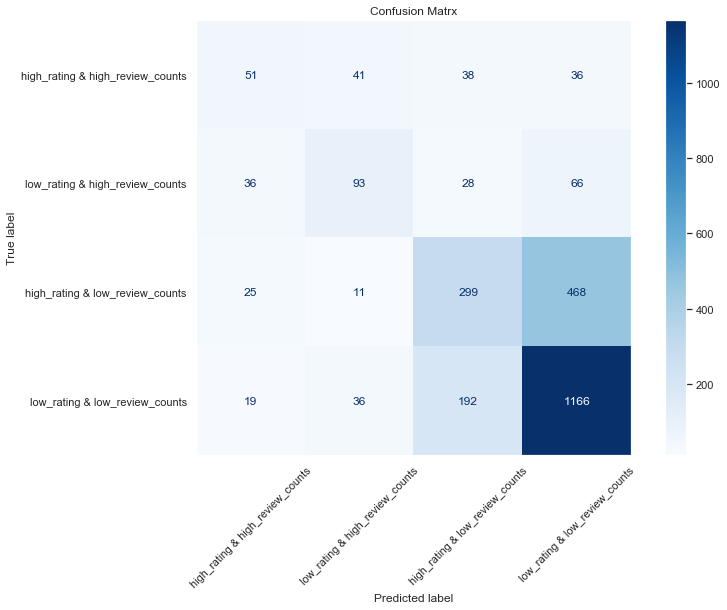

In [46]:
plot = plot_confusion_matrix(log_reg, 
                             X_test, 
                             y_test, 
                             display_labels=['high_rating & high_review_counts',
                                             'low_rating & high_review_counts',
                                             'high_rating & low_review_counts',
                                             'low_rating & low_review_counts'], 
                             cmap=plt.cm.Blues,
                             values_format='d')
plt.title('Confusion Matrx')
plt.xticks(rotation='45')
plt.grid(False)
plt.show()

#### <font color='blue'> c. XGBoost

Finally we select XGBoost which is based on tree methods to solve the prediction, and try to interpret it using `Shap` afterwards.

In [47]:
import xgboost as xgb

In [48]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=5,
    objective='multi:softmax',
    nthread=4,
    random_state=42,
    num_class=4)

In [49]:
xgb_param = xgb_clf.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_param['n_estimators'], nfold=5,
                  metrics='merror', early_stopping_rounds=50)

In [50]:
xgb_clf.set_params(n_estimators=cvresult.shape[0])
print(cvresult)

    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0            0.350107          0.004459          0.415237         0.008786
1            0.342865          0.003918          0.406681         0.007445
2            0.337023          0.005319          0.407668         0.006874
3            0.334061          0.004993          0.404704         0.010463
4            0.329575          0.005471          0.403223         0.009026
..                ...               ...               ...              ...
94           0.182727          0.001708          0.368992         0.010163
95           0.181781          0.001511          0.368992         0.009710
96           0.180423          0.001791          0.369650         0.009867
97           0.179765          0.001900          0.368663         0.009312
98           0.179148          0.001801          0.368334         0.008939

[99 rows x 4 columns]


In [51]:
xgb_clf.fit(X_train, y_train)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=99,
              n_jobs=1, nthread=4, num_class=4, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [55]:
y_pred_xgb_clf = xgb_clf.predict(X_test)

In [57]:
print('F1 score of XGBoost:', f1_score(y_test, y_pred_xgb_clf, average='macro'))

F1 score of XGBoost: 0.5187114409084372


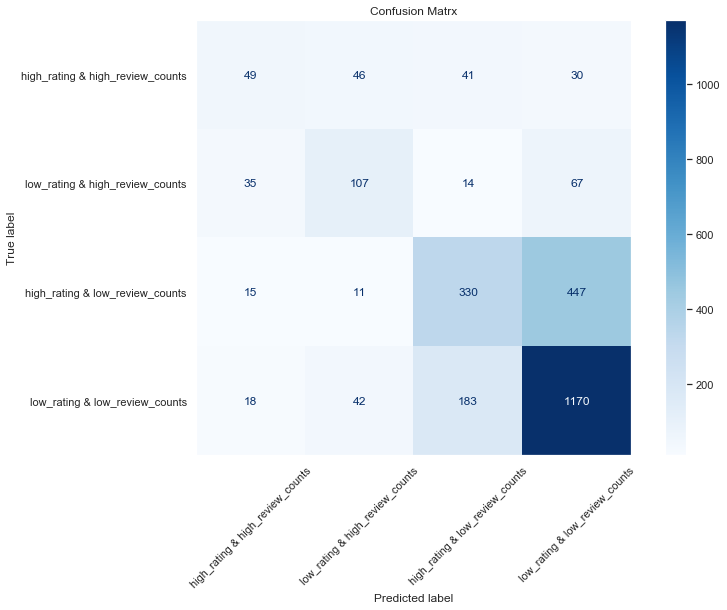

In [58]:
plot = plot_confusion_matrix(xgb_clf, 
                             X_test, 
                             y_test, 
                             display_labels=['high_rating & high_review_counts',
                                             'low_rating & high_review_counts',
                                             'high_rating & low_review_counts',
                                             'low_rating & low_review_counts'], 
                             cmap=plt.cm.Blues,
                             values_format='d')
plt.title('Confusion Matrx')
plt.xticks(rotation='45')
plt.grid(False)
plt.show()

XGBoost does not perform much better than logistic regression probably due to manual definiation of the popularity class and the highly imbalanced data, but both of them are much better than a random guess. Therefore we can assume the model is useful. 

---
### <font color='red'> 4. Feature analysis

In [59]:
import shap

In [60]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


> Overview of importance for most several important features

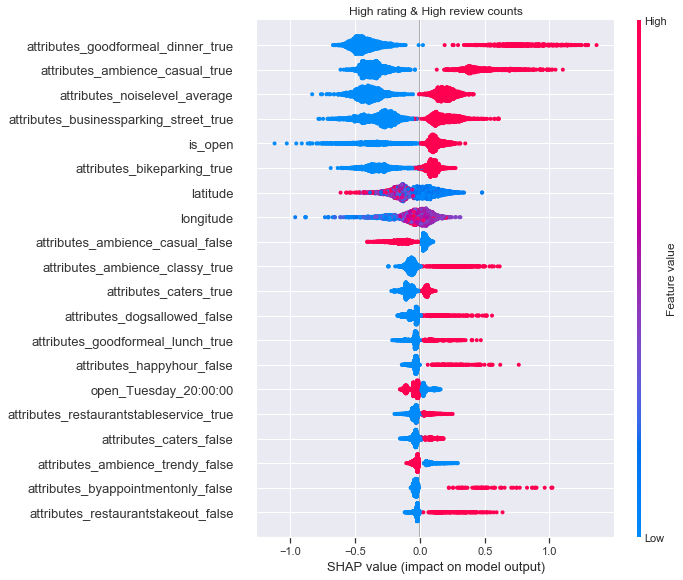

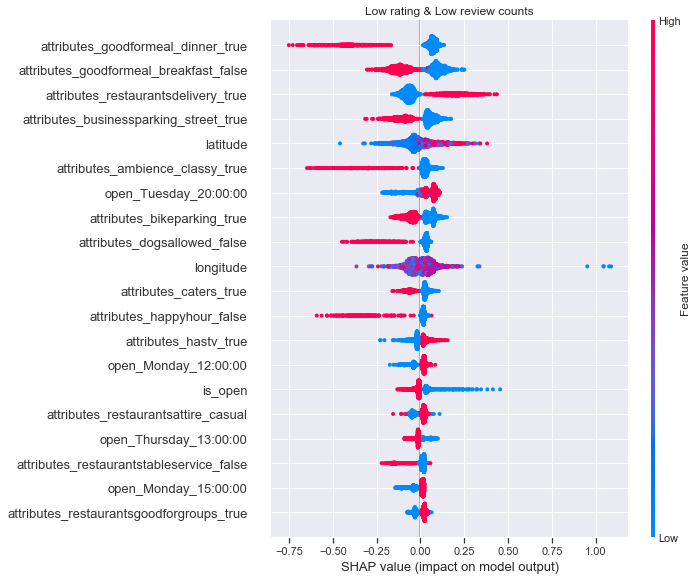

In [63]:
plt.title('High rating & High review counts')
shap.summary_plot(shap_values[0], X_test)
plt.title('Low rating & Low review counts')
shap.summary_plot(shap_values[3], X_test)

The importance for prediction of features are ordered from top to bottom(high to low), so the summary plots enable us to get a general view about what are the most important features for predicting different popularity classes. Here we only show `High rating & High review counts` and `Low rating & Low review counts` to compare the importance sharply.

All the parameters are binary except `latitude` and  `longitude`, hence from the summary plots above, we can interpret all the blue points are `False` while red points represent `True`. Let us look at some examples to see if the interpretation make sense here:

* **In `High rating & High review counts`:**
1. `attributes_goodformeal_dinner_true`: When this parameter is `True`, the SHAP value is positively high, which means it is more likely to be a `High rating & High review counts` restaurant with `attributes_goodformeal_dinner_true==Ture`. And we can find there are more restaurants to have this parameter to be true in `High rating & High review counts` which is also reasonable.

2. `is open`: When `is_open` is true, SHAP value is positive which means it is more likely for a restaurant to have `High rating & High review counts` while in the other side, if it is false, a restaurant tends to not be popular.

* **In `Low rating & Low review counts`:**
1. `attributes_goodformeal_dinner_true`: In contrast to the class `High rating & High review counts`, here we have more `True` indicating negative possibility on prediction of `Low rating & Low review counts` class, which means if a restaurant has `attributes_goodformeal_dinner_true` to be true, is will be unlikely to be in this least popular class.


2. `is_open`: When `is_open` is false, SHAP value is positive which means the closed restaurant is probably to be not popular in `Low rating & Low review counts` class.

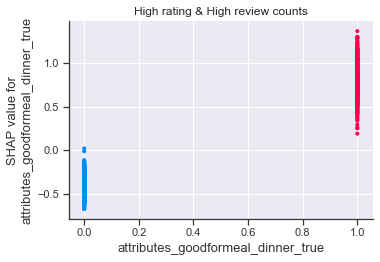

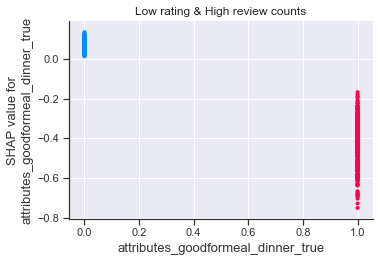

In [88]:
figure0 = plt.figure()
ax0 = figure0.add_subplot(2, 2, 1)
ax0.set_title("High rating & High review counts")
shap.dependence_plot(ind='attributes_goodformeal_dinner_true', interaction_index='attributes_goodformeal_dinner_true',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax0)


figure1 = plt.figure()
ax1 = figure1.add_subplot(2, 2, 2)
ax1.set_title("Low rating & High review counts")
ax0.set_title("High rating & High review counts")
shap.dependence_plot(ind='attributes_goodformeal_dinner_true', interaction_index='attributes_goodformeal_dinner_true',
                     shap_values=shap_values[3], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax1)


There are some not very meaningful parameters, which are probably because of the high ratio of missing data in some parameters. Hence we need to interpret these features very carefully, perhaps looking at the original data distribution without imputing can be helpful to have a more comprehensive point of view.

> `Latitude` and `Longitude` (continuous features):

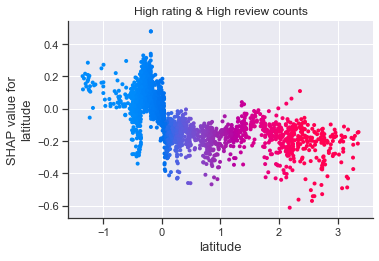

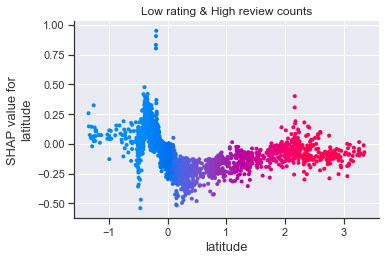

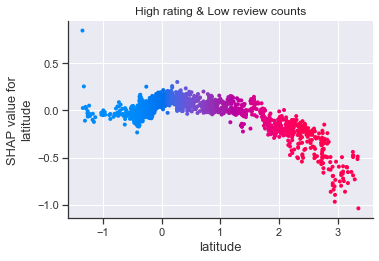

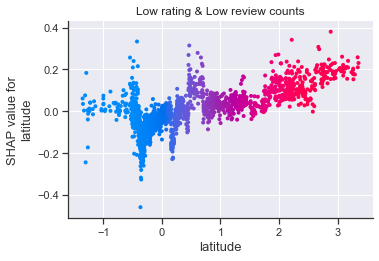

In [89]:
figure0 = plt.figure()
ax0 = figure0.add_subplot(2, 2, 1)
ax0.set_title("High rating & High review counts")
shap.dependence_plot(ind='latitude', interaction_index='latitude',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax0)


figure1 = plt.figure()
ax1 = figure1.add_subplot(2, 2, 2)
ax1.set_title("Low rating & High review counts")
shap.dependence_plot(ind='latitude', interaction_index='latitude',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax1)

figure2 = plt.figure()
ax2 = figure2.add_subplot(2, 2, 3)
ax2.set_title("High rating & Low review counts")
shap.dependence_plot(ind='latitude', interaction_index='latitude',
                     shap_values=shap_values[2], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax2)


figure3 = plt.figure()
ax3 = figure3.add_subplot(2, 2, 4)
ax3.set_title("Low rating & Low review counts")
shap.dependence_plot(ind='latitude', interaction_index='latitude',
                     shap_values=shap_values[3], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax3)

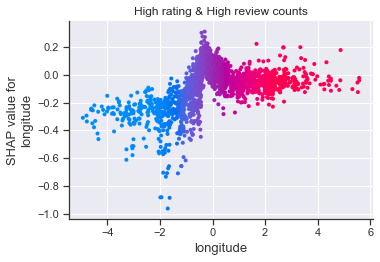

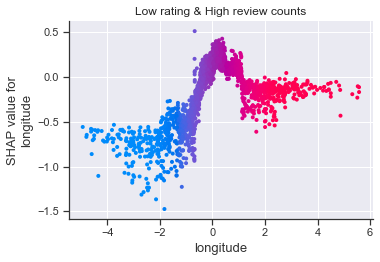

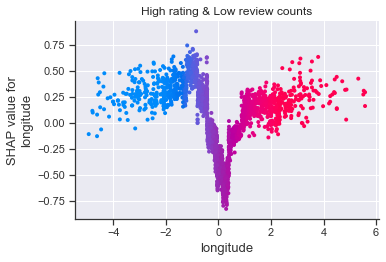

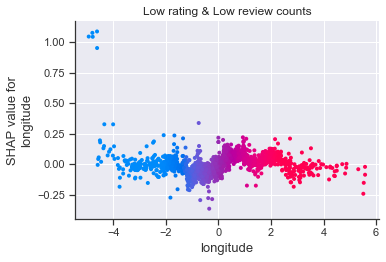

In [83]:
figure0 = plt.figure()
ax0 = figure0.add_subplot(2, 2, 1)
ax0.set_title("High rating & High review counts")
shap.dependence_plot(ind='longitude', interaction_index='longitude',
                     shap_values=shap_values[0], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax0)


figure1 = plt.figure()
ax1 = figure1.add_subplot(2, 2, 2)
ax1.set_title("Low rating & High review counts")
shap.dependence_plot(ind='longitude', interaction_index='longitude',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax1)

figure2 = plt.figure()
ax2 = figure2.add_subplot(2, 2, 3)
ax2.set_title("High rating & Low review counts")
shap.dependence_plot(ind='longitude', interaction_index='longitude',
                     shap_values=shap_values[2], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax2)


figure3 = plt.figure()
ax3 = figure3.add_subplot(2, 2, 4)
ax3.set_title("Low rating & Low review counts")
shap.dependence_plot(ind='longitude', interaction_index='longitude',
                     shap_values=shap_values[3], 
                     features=X_test,  
                     display_features=X_test,
                     ax=ax3)

From the dependence plots for latitude and logitude, we can spot some trends while they are not clear since we did not tranform the geo data points into proximity which would make better sense. We will do that solely in the next section.